<a href="https://colab.research.google.com/github/d4vidi4n/borradores/blob/main/EL7006_T1_RNN_P2_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <center> EL7006 - Tarea Nº1 <br /> Redes Recurrentes y LSTM  </center> </h1>
<h3> <center>Profesor: Pablo Estévez <br />
Profesor Auxiliar: Jhon Intriago <br />
Ayudantes: Sebastián Guzmán y Francisco Soto <br />
<h3><center>Semestre: Primavera 2025 </center></h3>

En esta tarea deberán contestar preguntas e implementar código relacionado a las redes neuronales recurrentes, en particular a las tipo Long Short-Term Memory (LSTM). Se recomienda leer el capítulo 10 de [Deep Learning Book](https://www.deeplearningbook.org/).

Para entregar su tarea, suba a u-cursos un archivo zip que contenga los notebooks de los problemas 1 y 2, desarrollados con sus respuestas e implementaciones, junto con cualquier archivo adicional necesario para ejecutarlos (excluyendo la base de datos). Sea claro en sus respuestas, y comente adecuadamente su código. No es necesario redactar un informe.

<h1><center><u>Problema 2: Procesamiento de voz usando RNN </u></center></h1>

En este problema, usted debe implementar y entrenar una red neuronal recurrente (RNN) para procesar señales de voz y predecir la palabra que mencionan. Debe comparar el desempeño obtenido al usar una Vanilla RNN y una LSTM RNN. Se les entrega todo el preprocesamiento de los datos en este notebook.

Si implementa sus modelos correctamente, debería obtener un accuracy en el rango 86-91 %.

<h2>Preliminares: Google Colab</h2>

Para evitar limitaciones de hardware, ejecute este notebook en Google Colab con GPU. Para ello siga estos pasos:

- Suba este notebook a su cuenta de Google Drive.
- Abra el notebook. Se hará automáticamente en Google Colab.
- En el menú "Entorno de ejecución", seleccione "Cambiar tipo de entorno de ejecución" y en "Acelerador por hardware" seleccione GPU.

Ejecute la siguiente celda para descargar la base de datos de este problema, crear la carpeta "speech_commands", y descomprimir la base de datos dentro de dicha carpeta.



In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir speech_commands
!tar -xf speech_commands_v0.02.tar.gz -C speech_commands

--2025-09-03 04:14:50--  https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  39.9MB/s    in 59s     

2025-09-03 04:15:50 (39.2 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



La celda anterior solo se necesita ejecutar la primera vez que conecta el notebook a un entorno de ejecución. En caso de dudas, puede inspeccionar los archivos que existen en su máquina asignada con la siguiente celda. Si la carpeta "speech_commands" ya existe, significa que ya existe la base de datos.

In [2]:
!ls

sample_data  speech_commands  speech_commands_v0.02.tar.gz


Google Colab tiene preinstaladas casi todas las librerías que necesitamos, excepto una. Ejecute la siguiente celda para instalar la librería "python_speech_features" que nos permitirá procesar las señales de voz.

In [3]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=92cf1309e9b60417d1c163a8f81c7ecfe587e589f78a971458b806b9386a23a4
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


<h2>Librerías</h2>

In [4]:
import os
import json
import time

import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from python_speech_features import mfcc
from scipy.io import wavfile

<h2>Procesamiento de voz con "Speech Commands Dataset"</h2>

La base de datos [Speech Commands](https://arxiv.org/abs/1804.03209) consiste en audios de un segundo de duración muestreados a 16kHz en donde diversas personas fueron grabadas diciendo comandos cortos en inglés. Incluye 10 comandos principales, algunas palabras irrelevantes, silencios, y ruidos de fondo. Su principal motivación es ser una puerta de entrada para experimentar con modelos de procesamiento de voz. El objetivo es detectar la pronunciación de una única palabra dentro de un pequeño conjunto de palabras posibles.

A continuación, puede escuchar un ejemplo de la clase "yes" y un ejemplo de la clase "no".

In [5]:
demo_yes = "speech_commands/yes/0a2b400e_nohash_0.wav"
demo_no = "speech_commands/no/0a2b400e_nohash_0.wav"
demo_tree = "speech_commands/tree/05cf43ef_nohash_0.wav"

In [6]:
print("Example from class 'tree'")
ipd.Audio(demo_tree)

Example from class 'tree'


In [7]:
print("Example from class 'yes'")
ipd.Audio(demo_yes)

Example from class 'yes'


In [8]:
print("Example from class 'no'")
ipd.Audio(demo_no)

Example from class 'no'


Normalmente, los modelos de procesamiento de voz no operan directamente sobre la señal de audio, sino que sobre una versión transformada de la misma que aprovecha el contenido localizado en diferentes bandas de frecuencia.

El método más común calcula [Mel-frequency Cepstrum Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). A grandes rasgos, se basa en segmentar la señal en varias ventanas consecutivas de ancho $winlen$ cuyos centros estas separados en $winstep$. En cada una de estas ventanas, se calculan coeficientes en base a la descomposición en frecuencia obtenida por la FFT.

Valores típicos para este dominio son ventanas de tamaño 25-40 milisegundos y separaciones que rondan el 50% del ancho. Además, en cada ventana se suelen calcular 13 coeficientes. Para disminuir el costo computacional, a lo largo de esta tarea se usa un ancho de ventana de 100 ms con paso de 50 ms. En consecuencia, cada señal de audio de 1 segundo se transforma en una secuencia de largo 19 en donde en cada paso existen 13 características.

A continuación, se grafican las señales de audio de los ejemplos escuchados anteriormente junto con sus MFCC.

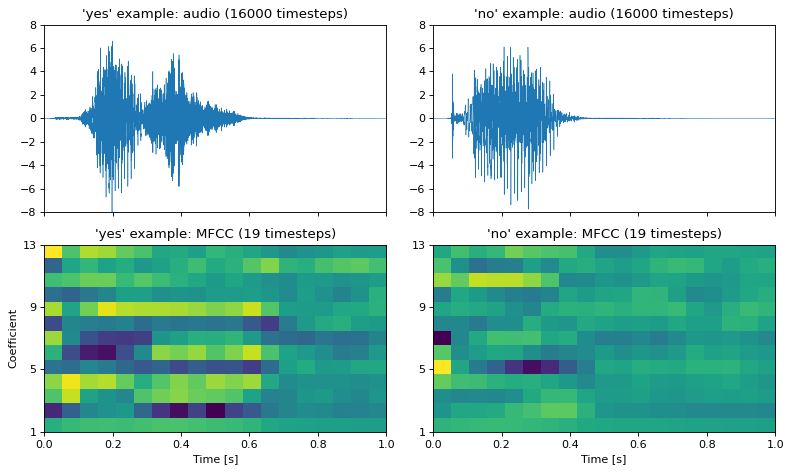

In [9]:
# Load demo data
sr, audio_yes = wavfile.read(demo_yes) #Entrega el tamaño del archivo de audio y el audio propiamente tal
sr, audio_no = wavfile.read(demo_no)
time_axis = np.arange(audio_yes.size) / sr

# Normalize audio to zero mean and unit variance
audio_yes = audio_yes.astype(np.float32) # porque se le cambia el formato?
audio_yes = (audio_yes - audio_yes.mean()) / audio_yes.std()
audio_no = audio_no.astype(np.float32)
audio_no = (audio_no - audio_no.mean()) / audio_no.std()

# Compute MFCC
winlen_ms = 100  # Window size, in miliseconds
winstep_ms = 0.5 * winlen_ms  # Step size for sliding window, in miliseconds
winlen = winlen_ms / 1000
winstep = winstep_ms / 1000
nfft = int(2 ** np.ceil(np.log2(sr * winlen)))  # Closest power of 2
mfcc_yes = mfcc(audio_yes, sr, winlen=winlen, winstep=winstep, numcep=13, nfft=nfft)
mfcc_no = mfcc(audio_no, sr, winlen=winlen, winstep=winstep, numcep=13, nfft=nfft)

# Plot audio and MFCC
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=80, sharex=True)
axes[0, 0].plot(time_axis, audio_yes, linewidth=0.5)
axes[0, 0].set_title("'yes' example: audio (%d timesteps)" % audio_yes.size)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([-8, 8])
axes[0, 1].plot(time_axis, audio_no, linewidth=0.5)
axes[0, 1].set_title("'no' example: audio (%d timesteps)" % audio_no.size)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([-8, 8])
axes[1, 0].imshow(mfcc_yes.T, interpolation="none", aspect="auto", extent=[0, 1, 1, 13], origin='lower')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_title("'yes' example: MFCC (%d timesteps)" % mfcc_yes.shape[0])
axes[1, 0].set_ylabel("Coefficient")
axes[1, 0].set_yticks([1, 5, 9, 13])
axes[1, 1].imshow(mfcc_no.T, interpolation="none", aspect="auto", extent=[0, 1, 1, 13], origin='lower')
axes[1, 1].set_yticks([1, 5, 9, 13])
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_title("'no' example: MFCC (%d timesteps)" % mfcc_no.shape[0])
plt.tight_layout()
plt.show()

<h2>Preparación de los datos</h2>

Por simplicidad, se reducirá la base de datos a los 10 comandos principales. Es decir, cada ejemplo solo puede pertenecer a una de las siguientes clases: "down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes". Por lo tanto, el modelo que implemente debe clasificar cada ejemplo en una de estas 10 posibles clases.

Tampoco se usarán perturbaciones de los datos para mejorar la generalización (data augmentation), tales como adición de ruido de fondo, pequeños cortes, desplazamientos del tono o dilataciones temporales, que son típicamente usadas en modelos del estado del arte.

Cada una de los 10 comandos mencionados anteriormente será asociado a una categoría numérica (etiqueta) que va del 0 al 9.

In [10]:
DATASET_PATH = "speech_commands"
WORDS = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]
WORDS_LABEL = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

En primer lugar, se limpiarán los datos removiendo aquellos ejemplos con una duración inferior a 1 segundo.

In [11]:
for word in WORDS:
    removed_files = 0
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    for single_file in files:
        filepath = os.path.join(folder_name, single_file)
        this_fs, this_audio = wavfile.read(filepath)
        if this_audio.size < this_fs:
            os.remove(filepath)
            removed_files += 1
    print("Word '%s': %d files removed" % (word, removed_files))

Word 'down': 337 files removed
Word 'go': 402 files removed
Word 'left': 299 files removed
Word 'no': 396 files removed
Word 'off': 318 files removed
Word 'on': 374 files removed
Word 'right': 330 files removed
Word 'stop': 309 files removed
Word 'up': 454 files removed
Word 'yes': 352 files removed


Como siguiente paso, se dividirá la base de datos en los conjuntos de entrenamiento, validación y prueba. Esta división se hará identificando cada sujeto grabado y asignándolo a cada conjunto de forma aleatoria (pero reproducible fijando una semilla) para que el 80% de los sujetos sea de entrenamiento, el 10% de validación, y el restante 10% de prueba. De esta forma, el modelo se evaluará siempre en grabaciones de sujetos que no fueron escuchados previamente.

In [12]:
train_fraction = 0.8
val_fraction = 0.1

# -----------------------------

# Fin and split subjects
subject_ids = []
for word in WORDS:
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    # First string of filename is subject ID
    word_subject_ids = [f.split("_")[0] for f in files]
    word_subject_ids = np.unique(word_subject_ids)
    subject_ids.extend(word_subject_ids)
subject_ids = list(set(subject_ids))
subject_ids.sort()

# Random but reproducible shuffle of all subjects found in dataset
subject_ids = np.random.RandomState(seed=0).permutation(subject_ids)
n_subjects = len(subject_ids)
cut_train = int(train_fraction * n_subjects)
cut_val = int((train_fraction + val_fraction) * n_subjects)
train_subjects = subject_ids[:cut_train]
val_subjects = subject_ids[cut_train:cut_val]
test_subjects = subject_ids[cut_val:]

# File split based on subject split
split_dict = {'train': {}, 'val': {}, 'test': {}}
for word in WORDS:
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    word_subject_ids = [f.split("_")[0] for f in files]
    n_files = len(files)
    word_train_files = [files[i] for i in range(n_files) if word_subject_ids[i] in train_subjects]
    word_val_files = [files[i] for i in range(n_files) if word_subject_ids[i] in val_subjects]
    word_test_files = [files[i] for i in range(n_files) if word_subject_ids[i] in test_subjects]
    print("'%s': Train %d - Val %d - Test %d" % (word, len(word_train_files), len(word_val_files), len(word_test_files)))
    split_dict['train'][word] = word_train_files
    split_dict['val'][word] = word_val_files
    split_dict['test'][word] = word_test_files

'down': Train 2805 - Val 413 - Test 362
'go': Train 2767 - Val 370 - Test 341
'left': Train 2779 - Val 373 - Test 350
'no': Train 2812 - Val 386 - Test 347
'off': Train 2741 - Val 349 - Test 337
'on': Train 2729 - Val 394 - Test 348
'right': Train 2756 - Val 370 - Test 322
'stop': Train 2829 - Val 402 - Test 332
'up': Train 2582 - Val 363 - Test 324
'yes': Train 2943 - Val 402 - Test 347


Finalmente, se procederá a calcular los MFCC de cada señal de audio de los conjuntos creados. Como se mencionó anteriormente, se usará un ancho de ventana de 100 ms, 50% de paso, y 13 coeficientes. Previo a calcular el MFCC, cada señal de audio $x$ se normaliza como:

$$ x \gets \frac{x - \mathrm{mean}(x)}{\mathrm{std}(x)}$$

In [13]:
winlen_ms = 100  # Window size, in miliseconds
winstep_ms = 0.5 * winlen_ms  # Step size for sliding window, in miliseconds
numcep = 13  # Number of MFCC

# -------------------------------
set_names = list(split_dict.keys())
winlen = winlen_ms / 1000
winstep = winstep_ms / 1000
print("Using winlen %s [s] and winstep %s [s]" % (winlen, winstep))
start_time = time.time()
dataset_dict = {}
for set_name in set_names:
    set_mfcc = []
    set_labels = []
    print("Processing %s set" % set_name)
    for label, word in zip(WORDS_LABEL, WORDS):
        folder_name = os.path.join(DATASET_PATH, word)
        set_files = split_dict[set_name][word]
        word_mfcc = []
        for single_file in set_files:
            filepath = os.path.join(folder_name, single_file)
            file_fs, file_audio = wavfile.read(filepath)
            nfft = int(2 ** np.ceil(np.log2(file_fs * winlen)))
            file_audio = file_audio.astype(np.float32)
            file_audio = (file_audio - file_audio.mean()) / file_audio.std()
            file_mfcc = mfcc(
                file_audio, file_fs,
                winlen=winlen, winstep=winstep, numcep=numcep, nfft=nfft)
            file_mfcc = file_mfcc.astype(np.float32)
            word_mfcc.append(file_mfcc)
        word_mfcc = np.stack(word_mfcc, axis=0)
        n_examples = word_mfcc.shape[0]
        word_labels = n_examples * [label]
        word_labels = np.array(word_labels).astype(np.int32)
        set_mfcc.append(word_mfcc)
        set_labels.append(word_labels)
        elap_time = time.time() - start_time
        print("    class %d ('%s') done (E.T. %1.2f [s])" % (label, word, elap_time))
    set_mfcc = np.concatenate(set_mfcc, axis=0)
    set_labels = np.concatenate(set_labels, axis=0)
    dataset_dict[set_name] = {'x': set_mfcc, 'y': set_labels}
elap_time = time.time() - start_time
print("Data preparation done (E.T. %1.2f [s])" % elap_time)
for set_name in ['train', 'val', 'test']:
    np.savez(
        'win%d_%s.npz' % (winlen_ms, set_name),
        x=dataset_dict[set_name]['x'],
        y=dataset_dict[set_name]['y'])
    print("Checkpoint created win%d_%s.npz" % (winlen_ms, set_name))

Using winlen 0.1 [s] and winstep 0.05 [s]
Processing train set
    class 0 ('down') done (E.T. 12.25 [s])
    class 1 ('go') done (E.T. 20.35 [s])
    class 2 ('left') done (E.T. 27.92 [s])
    class 3 ('no') done (E.T. 35.50 [s])
    class 4 ('off') done (E.T. 43.83 [s])
    class 5 ('on') done (E.T. 51.90 [s])
    class 6 ('right') done (E.T. 59.02 [s])
    class 7 ('stop') done (E.T. 66.44 [s])
    class 8 ('up') done (E.T. 73.66 [s])
    class 9 ('yes') done (E.T. 81.01 [s])
Processing val set
    class 0 ('down') done (E.T. 82.03 [s])
    class 1 ('go') done (E.T. 82.96 [s])
    class 2 ('left') done (E.T. 84.42 [s])
    class 3 ('no') done (E.T. 85.71 [s])
    class 4 ('off') done (E.T. 86.55 [s])
    class 5 ('on') done (E.T. 87.50 [s])
    class 6 ('right') done (E.T. 88.38 [s])
    class 7 ('stop') done (E.T. 89.36 [s])
    class 8 ('up') done (E.T. 90.23 [s])
    class 9 ('yes') done (E.T. 91.22 [s])
Processing test set
    class 0 ('down') done (E.T. 92.08 [s])
    class 1 (

<h2>Últimos ajustes de datos</h2>

Los conjuntos de entrenamiento, validación y prueba de secuencias de MFCC generados anteriormente son tres pares $(x, y)$ de arreglos numpy. Los arreglos de entrada ($x$) contienen números reales y poseen dimensiones [número de ejemplos, número de pasos, número de características]. Específicamente, poseen dimensiones [?, 19, 13]. Por otro lado, los arreglos de salida ($y$) contienen números enteros y poseen dimensiones [número de ejemplos,], en donde cada fila de $y$ contiene la etiqueta de la fila correspondiente en $x$.

Estos conjuntos fueron guardados en los archivos "win100_SETNAME.npz". No es necesario que vuelva a ejecutar la preparación de los datos si estos archivos ya existen en su máquina, ya que la siguiente celda carga los datos a partir de estos archivos.


In [14]:
# Load from checkpoint
winlen_ms = 100
set_names = ['train', 'val', 'test']
verification = [os.path.isfile('win%d_%s.npz' % (winlen_ms, set_name)) for set_name in set_names]
exists_checkpoint = np.all(verification)
if exists_checkpoint:
    print("Checkpoint found.")
    dataset_dict = {}
    for set_name in set_names:
        set_data = np.load('win%d_%s.npz' % (winlen_ms, set_name))
        dataset_dict[set_name] = {'x': set_data['x'], 'y': set_data['y']}
        n_examples = dataset_dict[set_name]['y'].size
        n_classes = len(np.unique(dataset_dict[set_name]['y']))
        print("%s set with %d examples and %d classes" % (set_name, n_examples, n_classes))
else:
    raise FileNotFoundError("Some or all checkpoints were not found.")

# Unpacking arrays
x_train, y_train = dataset_dict['train']['x'], dataset_dict['train']['y']
x_val, y_val = dataset_dict['val']['x'], dataset_dict['val']['y']
x_test, y_test = dataset_dict['test']['x'], dataset_dict['test']['y']

Checkpoint found.
train set with 27743 examples and 10 classes
val set with 3822 examples and 10 classes
test set with 3410 examples and 10 classes


Estos datos se normalizarán usando las estadísticas del conjunto de entrenamiento. Cada una de las 13 características se normalizará por separado. Finalmente, el conjunto de entrenamiento se revolverá de forma aleatoria (pero reproducible fijando una semilla).

In [15]:
# Normalize features with train statistics across all examples and timesteps
x_train_mean = x_train.mean(axis=(0, 1))  # Mean of each of the 13 features
x_train_std = x_train.std(axis=(0, 1))  # Std of each of the 13 features
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

# # Random but reproducible shuffle of the training set
n_train_data = y_train.size
idx_permuted = np.random.RandomState(seed=0).permutation(range(n_train_data))
x_train = x_train[idx_permuted]
y_train = y_train[idx_permuted]

# Shape of data is [batch, timesteps, feats]
n_steps = x_train.shape[1]
n_feats = x_train.shape[2]
n_classes = len(np.unique(y_train))
print("%d timesteps, %d features, %d classes" % (n_steps, n_feats, n_classes))

19 timesteps, 13 features, 10 classes


<h2>Vanilla RNN: Implementación</h2>

Ahora que los datos han sido completamente preprocesados, usted debe implementar una red neuronal recurrente del tipo "vanilla" o básica para esta tarea de clasificación.

Sea $x=\{x_1, x_2, \ldots, x_T\}$ una secuencia de entrada de $T=19$ pasos y $F=13$ características por paso. Es decir, $x_k\in\mathbb{R}^F,\ k\in\{1,2,\ldots,T\}$. Sea $y\in\{0,1,\ldots,C-1\}$ la clase a la que pertenece la secuencia $x$, de $C=10$ clases posibles.

Se solicita implementar la siguiente RNN:

$$ h_0 = \vec{0}$$
$$ h_k = \tanh \left( W\begin{bmatrix}x_k\\h_{k-1}\end{bmatrix} + b \right),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k\in\mathbb{R}^H$ es el estado oculto, $H$ es la dimensionalidad de la capa recurrente, $h_0$ es un estado inicial nulo, $W$ y $b$ son los pesos y sesgos de la capa recurrente, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.

Especificaciones del modelo:
- Dimensionalidad $H=32$.
- Función de pérdida cross-entropy.
- Optimizador Adam con $\beta_{1}=0.9$ y $\beta_{2}=0.999$ (valores típicos).
- Entrenamiento por 200 épocas, validando en el conjunto de validación completo al final de cada época, con tamaño de batch 64.
- Al finalizar el entrenamiento se debe preservar el mejor modelo, definido como aquél de mínima cross-entropy de validación.

Instrucciones de programación:
- Es libre de elegir la librería de redes neuronales de su preferencia. Se recomienda Tensorflow o Pytorch.
- Independiente de la librería elegida, ustedes deben implementar las capas recurrentes. Es decir, para la arquitectura de la red neuronal solo se admite que usen de la librería capas fully-connected (nn.Linear en Pytorch, layers.Dense en Tensorflow), funciones de activación, y operaciones elementales como concatenación, suma, producto, multiplicación de matrices. Si lo desea, puede evitar usar capas fully-connected y simplemente crear y utilizar los pesos y sesgos directamente. Fuera de la implementación de las capas, es libre de usar todas las herramientas de la librería para construir el modelo y entrenarlo.
- Por simplicidad, se sugiere implementar la recurrencia con un ciclo for, pero no es obligatorio.
- Debe implementar su modelo en una clase llamada "ModelVanillaRNN".
- La clase debe implementar un método "fit" para entrenar en datos $(x_{train}$, $y_{train})$ y validar en datos $(x_{val}, y_{val})$. Al entrenar el modelo, se debe entregar la evolución de cross-entropy y accuracy a lo largo de las épocas.
- La clase debe implementar un método "evaluate" para evaluar el accuracy en datos $(x, y)$.
- Es libre de implementar métodos adicionales si lo desea.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [16]:
import torch
import torch.nn as nn

device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

In [17]:
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

In [19]:
x_train.shape

(27743, 19, 13)

In [144]:
class ModelVanillaRNN():
  def __init__(
      self,
      learning_rate,
      n_input_features=13,
      n_input_steps=19,
      n_hidden_dimension=32,
      n_classes=10,
      batch_size=64,
      n_epochs=200
  ):
      self.learning_rate = learning_rate
      self.n_input_features = n_input_features
      self.n_input_steps = n_input_steps
      self.n_hidden_dimension = n_hidden_dimension
      self.n_classes = n_classes
      self.batch_size = batch_size
      self.n_epochs = n_epochs

      self.Wxh = nn.Linear(self.n_input_features, self.n_hidden_dimension).to(device)
      self.Whh = nn.Linear(self.n_hidden_dimension, self.n_hidden_dimension).to(device)
      self.Why = nn.Linear(self.n_hidden_dimension, self.n_classes).to(device)

      # self.rnn = nn.Sequential(nn.Linear(self.n_input_features, self.n_hidden_dimension),
      #                          nn.Tanh(),
      #                          nn.Linear(self.n_hidden_dimension, self.n_classes)).to(device)
      # self.rnn = nn.Sequential(nn.Linear(self.n_input_features, self.n_hidden_dimension),
      #                          nn.Tanh()).to(device)
                              #  Despues tengo que ejecutar
                              #  self.rnn.add_module(nn.Linear(self.n_hidden_dimension, self.n_classes))
      # Agrupa los parámetros de todas las capas que forman la RNN
      self.optimizer = torch.optim.Adam(
          list(self.Wxh.parameters()) +
          list(self.Whh.parameters()) +
          list(self.Why.parameters()),
          lr=self.learning_rate,
          betas=(0.9, 0.999))

  def fit(self, x_train, y_train, x_val, y_val):
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

    training_curves = []
    val_train_curves = []

    # Cáculo de la red, bucle en las épocas
    for epoch in range(1, self.n_epochs + 1):

      train_loss_per_sequence = []
      val_loss_per_sequence = []
      print(epoch)

      loss = 0

      # Cálculo de la red, bucle en la capa de recurrencia ( 0 -> T=19 )
      for j in range(self.n_input_steps):

        #Inicialización del estado h=0
        h = torch.zeros(self.batch_size, self.n_hidden_dimension).to(device)

        # Se crean los dataloaders para entregarle los datos a la red en batches de 64, se repite esto para cada T
        # data_dict = [ {"features":dataset_dict['train']['x'][i,j,:], "labels":y_train[i]} for i in range(len(y_train)) ]
        # dataloader_train = torch.utils.data.DataLoader(data_dict, batch_size=self.batch_size, num_workers=0, drop_last=True)

        # data_dict = [ {"features":dataset_dict['val']['x'][i,j,:], "labels":y_val[i]} for i in range(len(y_val)) ]
        # dataloader_val = torch.utils.data.DataLoader(data_dict, batch_size=self.batch_size, num_workers=0, drop_last=True)

        batch_weights_train = []
        batch_weights_val = []

        train_loss_per_batch = []
        val_loss_per_batch = []

        # Cálculo de la red, bucle en el dataloader (todos los batches)
        t=0
        for batch in dataloader_train:
          t+=1
          self.Wxh.train()
          self.Whh.train()
          self.Why.train()

          x_t = batch["features"].to(device)
          targets = batch["labels"].to(device) # Correponde a las clases de los datos

          # if t==434:
          #   print(self.Whh(h).size(dim=0))

          # 1) Update hidden state
          h = torch.tanh(self.Wxh(x_t) + self.Whh(h.detach())) #"corta" la dependencia de h con el paso anterior usando .detach():
          # h = torch.tanh(self.Wxh(x_t) + self.Whh(h))

          # 2) Output from current hidden state
          y_pred = self.Why(h).to(device)

          # 3) Loss
          loss += criterion(y_pred, targets)

          # Igualar a 0 los gradientes de todas las variables optimizadas
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # Curva de entrenamiento
          train_loss_per_batch.append(loss.item())

          # Tamaño de cada batch para cáclulo de promedio ponderado
          batch_weights_train.append(targets.size(0))

          # prep model for evaluation
          self.Wxh.eval()
          self.Whh.eval()
          self.Why.eval()

          # for batch in dataloader_val:
          #   with torch.no_grad():
          #     inputs = batch["features"].to(device)
          #     targets = batch["labels"].to(device)
          #     output = self.rnn(inputs)
          #     loss = criterion(output, targets)
        # print(len(batch_weights_train))
        train_loss_per_sequence.append(np.average(train_loss_per_batch, weights=batch_weights_train))
        # break



        # val_in_train_curves.append(loss.item())
        # training_curves = None
      #Calculo de un promedio ponderado
      training_curves.append(np.average(train_loss_per_sequence))
    plt.plot(training_curves, label='Training')
    plt.plot(val_train_curves, label='Validation')
    plt.legend()
    plt.show()
    return training_curves

  def evaluate(self, x, y):
      # --- Your code goes here ---
      accuracy = 10
      return accuracy

In [75]:
# len(dataset_dict['train']['x'][:,0,0]) # Todas las observaciones (N e [0,~27000])
# len(dataset_dict['train']['x'][0,:,0]) # Todas las secuencias (T e [0,19])
# len(dataset_dict['train']['x'][0,0,:]) # Todas las características (T e [0,13])

27743

In [19]:
aux_dict = [ {"features":dataset_dict['train']['x'][i,0,:], "labels":y_train[i]} for i in range(len(dataset_dict['train']['x'][0,0,:])) ]

<h2>Vanilla RNN: Entrenamiento</h2>

Con su modelo ya implementado, es hora de entrenar. Se solicita entrenar su modelo usando primero una tasa de aprendizaje 0.001 y luego una tasa de aprendizaje de 0.0005. En cada caso, debe entrenar su modelo 5 veces.

Usando estas 5 corridas, usted debe:
- Reportar el promedio y desviación estándar del accuracy en el conjunto de validación entregado por el mejor modelo de cada corrida.
- Reportar el promedio y desviación estándar del accuracy en el conjunto de prueba entregado por el mejor modelo de cada corrida.
- Graficar las 5 curvas de cross-entropy de validación superpuestas, destacando en cada una la iteración en donde se encontró el mejor modelo (mínima pérdida de validación).
- Graficar las 5 curvas de accuracy de validación superpuestas, destacando en cada una la iteración en donde se encontró el mejor modelo (mínima pérdida de validación).

In [145]:
learning_rate = 0.001

vanilla_rnn_training_curves_list = []
vanilla_rnn_val_accuracy_list = []
vanilla_rnn_test_accuracy_list = []
for i in range(1):
    # Create model
    my_rnn = ModelVanillaRNN(learning_rate=learning_rate)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val)
#     # Evaluate model
#     val_accuracy = my_rnn.evaluate(x_val, y_val)
#     test_accuracy = my_rnn.evaluate(x_test, y_test)
#     # Save reports for later
#     vanilla_rnn_training_curves_list.append(training_curves)
#     vanilla_rnn_val_accuracy_list.append(val_accuracy)
#     vanilla_rnn_test_accuracy_list.append(test_accuracy)
# print("Learning rate: %s" % learning_rate)
# print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
#     np.mean(vanilla_rnn_val_accuracy_list),
#     np.std(vanilla_rnn_val_accuracy_list)))
# print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
#     np.mean(vanilla_rnn_test_accuracy_list),
#     np.std(vanilla_rnn_test_accuracy_list)))

1


TypeError: list indices must be integers or slices, not str

In [ ]:
# --- Your plots go here ---


In [ ]:
learning_rate = 0.0005

vanilla_rnn_training_curves_list = []
vanilla_rnn_val_accuracy_list = []
vanilla_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelVanillaRNN(learning_rate=learning_rate)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val)
    # Evaluate model
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    vanilla_rnn_training_curves_list.append(training_curves)
    vanilla_rnn_val_accuracy_list.append(val_accuracy)
    vanilla_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_val_accuracy_list),
    np.std(vanilla_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_test_accuracy_list),
    np.std(vanilla_rnn_test_accuracy_list)))

In [ ]:
# --- Your plots go here ---


<h2>LSTM RNN: Implementación</h2>

Ahora usted debe implementar una red neuronal recurrente del tipo LSTM en dos versiones.

1) Se solicita implementar la siguiente RNN usando la capa LSTM típica (sin "peepholes connections"):

$$ h_0 = \vec{0}$$
$$ c_0 = \vec{0}$$
$$ h_k, c_k = \mathrm{LSTM}(x_k, h_{k-1}, c_{k-1}),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k,\ c_k\in\mathbb{R}^H$ son respectivamente el estado oculto y la memoria, $H$ es la dimensionalidad de la capa recurrente, $h_0,\ c_0$ son estados iniciales nulos, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.

Las especificaciones del modelo y las instrucciones de programación son las mismas que las entregadas para el modelo vanilla RNN, a excepción del nombre de la clase que debe ser "ModelLSTM".

Siguiendo buenas prácticas, debe inicializar los sesgos de la compuerta de olvido (forget gate) en 1.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

2) Se solicita implementar una LSTM  típica (sin "peepholes connections") con un mecanismo de atención en el contexto de clasificación.


Supongamos lo siguiente:
- La salida del LSTM está representada por $ \mathbf{h} $, que es una matriz de forma $ (T \times d) $, donde $ T $ es la longitud de la secuencia y $ d $ es la dimensión del vector oculto.
- La transformación lineal en el mecanismo de atención está representada por un vector de pesos $ \mathbf{W}_{\text{attn}} $, que es un vector de forma $ (d \times 1) $.

El mecanismo de atención se puede describir mediante los siguientes pasos:

1. **Transformación Lineal:**

   
   $$\mathbf{a} = \mathbf{h} \cdot \mathbf{W}_{\text{attn}}$$
   

   Aquí, $ \mathbf{a} $ es un vector de forma $ (T \times 1) $, y cada elemento $ a_i $ representa el puntaje de atención para el paso de tiempo correspondiente $ i $.

2. **Operación de Compresión (Squeeze):**

   $$
   \mathbf{a} = \text{Squeeze}(\mathbf{a})
   $$

   Después de la operación de compresión, $ \mathbf{a} $ se convierte en un vector de forma $ (T) $, donde cada $ a_i $ corresponde al puntaje de atención para el paso de tiempo $ i $.

3. **Operación de Softmax:**

   $$
   \alpha_i = \frac{\exp(a_i)}{\sum_{j=1}^{T} \exp(a_j)}
   $$

   Esta ecuación aplica la función softmax para obtener los pesos de atención normalizados $ \alpha_i $, donde $ \sum_{i=1}^{T} \alpha_i = 1 $ y $ \alpha_i \geq 0 $.

4. **Expansión de Dimensión:**

   $$
   \alpha_i = \text{expansion}(\alpha_i)
   $$

   Aquí, se expande la dimensión de los pesos de atención para que coincidan con la forma de $ \mathbf{h}$, resultando en un tensor de forma $ (T \times 1)$ que luego puede ser multiplicado elemento a elemento con $ \mathbf{h}$.

5. **Ponderación de la Salida del LSTM:**

   $$
   \mathbf{h'} = \mathbf{h} \times \alpha
   $$

   Se multiplica elemento a elemento la salida del LSTM $ \mathbf{h}$ por los pesos de atención $ \alpha$ para obtener $ \mathbf{h'}$, que es un tensor de forma $ (T \times d)$.

6. **Cálculo Final:**

   $$ z = W_z\sum_{i=1}^{T} \mathbf{h'}_i+b_z$$
   $$\hat{y} = \mathrm{argmax}(z)$$


Todas las operaciones anteriores no incluyen el batch_size, ud tiene que adaptarlo en su código.


Material de referencia:

https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/context-vector.png



In [ ]:
class ModelLSTM():
    def __init__(
        self,
        learning_rate,
        n_input_features=13,
        n_input_steps=19,
        n_hidden_dimension=32,
        n_classes=10,
        batch_size=64,
        n_epochs=200
    ):
        self.learning_rate = learning_rate
        self.n_input_features = n_input_features
        self.n_input_steps = n_input_steps
        self.n_hidden_dimension = n_hidden_dimension
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        # --- Your code goes here ---

    def fit(self, x_train, y_train, x_val, y_val):
        # --- Your code goes here ---
        training_curves = None
        return training_curves

    def evaluate(self, x, y):
        # --- Your code goes here ---
        accuracy = 10
        return accuracy

<h2>LSTM RNN: Entrenamiento</h2>

Entrene su modelo LSTM con las mismas instrucciones entregadas para vanilla RNN.

In [ ]:
learning_rate = 0.001

lstm_rnn_training_curves_list = []
lstm_rnn_val_accuracy_list = []
lstm_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelLSTM(learning_rate=learning_rate)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val)
    # Evaluate model
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    lstm_rnn_training_curves_list.append(training_curves)
    lstm_rnn_val_accuracy_list.append(val_accuracy)
    lstm_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_val_accuracy_list),
    np.std(lstm_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_test_accuracy_list),
    np.std(lstm_rnn_test_accuracy_list)))

In [ ]:
# --- Your plots go here ---


In [ ]:
learning_rate = 0.0005

lstm_rnn_training_curves_list = []
lstm_rnn_val_accuracy_list = []
lstm_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelLSTM(learning_rate=learning_rate)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val)
    # Evaluate model
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    lstm_rnn_training_curves_list.append(training_curves)
    lstm_rnn_val_accuracy_list.append(val_accuracy)
    lstm_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_val_accuracy_list),
    np.std(lstm_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_test_accuracy_list),
    np.std(lstm_rnn_test_accuracy_list)))

In [ ]:
# --- Your plots go here ---


<h2>Análisis de resultados</h2>

Responda las siguientes preguntas en base a sus resultados.

1) Indique la mejor tasa de aprendizaje para cada arquitectura. ¿Existen diferencias significativas en el entrenamiento al cambiar la tasa de aprendizaje? ¿Cuál arquitectura es más estable? Explique diferencias en base a sus conocimientos teóricos.

Respuesta:

2) Compare Vanilla RNN y LSTM en términos del desempeño alcanzado, el costo computacional, el número de iteraciones necesarias para encontrar el mejor modelo, y la sensibilidad a la inicialización de la red ¿Cuál arquitectura es más fácil de entrenar? Explique diferencias en base a sus conocimientos teóricos.

Respuesta:

3) Compare la LSTM y la Att-LSTM en términos del desempeño alcanzado, el costo computacional, el número de iteraciones necesarias para encontrar el mejor modelo, y la sensibilidad a la inicialización de la red ¿Cuál arquitectura es más fácil de entrenar? Explique diferencias en base a sus conocimientos teóricos.

Respuesta:

4) El sobre-ajuste refleja que el modelo tiene una gran capacidad con respecto a la base de datos, ya que es capaz de memorizar los datos de entrenamiento de forma relativamente fácil ¿En qué arquitectura es posible observar sobre-ajuste? ¿Por qué una arquitectura se logra sobre-ajustar y la otra no? ¿Qué sugeriría para aprovechar la mayor capacidad del modelo que se logra sobre-ajustar y mejorar el desempeño, sin modificar el tamaño de sus capas neuronales?

Respuesta:

<h2>Pregunta Bonus + 0.5 </h2>

Implemente este modelo LSTM https://github.com/NX-AI/xlstm y ejecute un nuevo entrenamiento con los datos descritos anteriormente y compare el rendimiento logrado. Explique diferencias de la LSTM y la xLSTM en base a sus conocimientos teóricos.


Respuesta: